# Project A: Knowledge Distillation for Building Lightweight Deep Learning Models in Visual Classification Tasks

In [1]:
import tensorflow.compat.v2 as tf
import tensorflow_datasets as tfds
from tensorflow.keras import datasets, layers, models
from typing import Union
import matplotlib.pyplot as plt
import numpy as np

tf.enable_v2_behavior()

builder = tfds.builder('mnist')
BATCH_SIZE = 256
NUM_EPOCHS = 12
NUM_CLASSES = 10  # 10 total classes.

# Data loading

In [2]:
# Load train and test splits.
def preprocess(x):
  image = tf.image.convert_image_dtype(x['image'], tf.float32)
  class_labels = tf.one_hot(x['label'], builder.info.features['label'].num_classes)
  return image, class_labels


mnist_train = tfds.load('mnist', split='train', shuffle_files=False).cache()
mnist_train = mnist_train.map(preprocess)
mnist_train = mnist_train.shuffle(builder.info.splits['train'].num_examples)
mnist_train = mnist_train.batch(BATCH_SIZE, drop_remainder=True)

mnist_test = tfds.load('mnist', split='test').cache()
mnist_test = mnist_test.map(preprocess).batch(BATCH_SIZE)

# Model creation

In [3]:
#@test {"output": "ignore"}

# Build CNN teacher.
cnn_model = tf.keras.Sequential([


# your code start from here for stpe 2
layers.Conv2D(32, (3, 3), strides = (1,1), activation='relu', input_shape=(28, 28, 1)),
layers.MaxPooling2D((2, 2), strides = (1,1)),
layers.Conv2D(64, (3, 3), activation='relu'),
layers.Flatten(),
layers.Dropout(rate = 0.5),
layers.Dense(128, activation='relu'),
layers.Dropout(rate = 0.5),
layers.Dense(10)
])

# Build fully connected student.
fc_model = tf.keras.Sequential([

# your code start from here for step 2
layers.Flatten(),
layers.Dense(784, activation='relu'),
layers.Dense(784, activation='relu'),
layers.Dense(10)
])

In [4]:
# print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('Cuda')))

In [4]:
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 25, 25, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 23, 23, 64)        18496     
                                                                 
 flatten (Flatten)           (None, 33856)             0         
                                                                 
 dropout (Dropout)           (None, 33856)             0         
                                                                 
 dense (Dense)               (None, 128)               4333696   
                                                        

In [5]:
fc_model.build(input_shape=(256,28,28,1))
fc_model.summary()

Model: "sequential_1"
_________________________________________________________________


 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (256, 784)                0         
                                                                 
 dense_2 (Dense)             (256, 784)                615440    
                                                                 
 dense_3 (Dense)             (256, 784)                615440    
                                                                 
 dense_4 (Dense)             (256, 10)                 7850      
                                                                 
Total params: 1238730 (4.73 MB)
Trainable params: 1238730 (4.73 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


# Teacher loss function

In [9]:
@tf.function
def compute_teacher_loss(images, labels):
  """Compute subclass knowledge distillation teacher loss for given images
     and labels.

  Args:
    images: Tensor representing a batch of images.
    labels: Tensor representing a batch of labels.

  Returns:
    Scalar loss Tensor.
  """
  class_logits = cnn_model(images, training=True)
  # print(subclass_logits)
  
  # Compute cross-entropy loss for subclasses.

  # your code start from here for step 3
  cross_entropy_loss_value = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels, class_logits))
  # cross_entropy_loss_value = cross_entropy_loss_value(labels, subclass_logits)



  return cross_entropy_loss_value

# Student loss function

In [10]:
#@test {"output": "ignore"}

# Hyperparameters for distillation (need to be tuned).
ALPHA = 0.5 # task balance between cross-entropy and distillation loss
DISTILLATION_TEMPERATURE = 4. #temperature hyperparameter

def distillation_loss(teacher_logits: tf.Tensor, student_logits: tf.Tensor,
                      temperature: Union[float, tf.Tensor]):
  """Compute distillation loss.

  This function computes cross entropy between softened logits and softened
  targets. The resulting loss is scaled by the squared temperature so that
  the gradient magnitude remains approximately constant as the temperature is
  changed. For reference, see Hinton et al., 2014, "Distilling the knowledge in
  a neural network."

  Args:
    teacher_logits: A Tensor of logits provided by the teacher.
    student_logits: A Tensor of logits provided by the student, of the same
      shape as `teacher_logits`.
    temperature: Temperature to use for distillation.

  Returns:
    A scalar Tensor containing the distillation loss.
  """
 # your code start from here for step 3
  soft_targets = tf.nn.softmax(teacher_logits / temperature)
  # print("soft targets = ", soft_targets)

  return tf.reduce_mean(
      tf.nn.softmax_cross_entropy_with_logits(
          soft_targets, student_logits / temperature)) * temperature ** 2

def compute_student_loss(images, labels, distillation_temperature = DISTILLATION_TEMPERATURE, alpha = ALPHA):
  """Compute subclass knowledge distillation student loss for given images
     and labels.

  Args:
    images: Tensor representing a batch of images.
    labels: Tensor representing a batch of labels.

  Returns:
    Scalar loss Tensor.
  """
  student_class_logits = fc_model(images, training=True)
  # print("student_subclass_logits = ", student_subclass_logits)

  # Compute subclass distillation loss between student subclass logits and
  # softened teacher subclass targets probabilities.

  # your code start from here for step 3

  teacher_class_logits = cnn_model(images, training=False)
  distillation_loss_value = distillation_loss(teacher_logits = teacher_class_logits, student_logits = student_class_logits, temperature = distillation_temperature)

  # print("distillation_loss = ", distillation_loss_value)  
  # Compute cross-entropy loss with hard targets.

  # your code start from here for step 3

  cross_entropy_loss_value = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels, student_class_logits))
  # print("ce loss = ", cross_entropy_loss_value)
  # cross_entropy_loss_value = cross_entropy_loss_value(labels, student_subclass_logits)

  # return alpha * (distillation_loss_value + cross_entropy_loss_value)
  return alpha * cross_entropy_loss_value + distillation_loss_value

In [11]:
images = tf.ones((256,28,28,1))
labels = tf.ones((256,10))

loss = compute_student_loss(images, labels, distillation_temperature=DISTILLATION_TEMPERATURE, alpha = ALPHA)
print ("total student loss = ", loss)

total student loss =  tf.Tensor(49.30871, shape=(), dtype=float32)


# Train and evaluation

In [13]:
@tf.function
def compute_num_correct(model, images, labels):
  """Compute number of correctly classified images in a batch.

  Args:
    model: Instance of tf.keras.Model.
    images: Tensor representing a batch of images.
    labels: Tensor representing a batch of labels.

  Returns:
    Number of correctly classified images.
  """
  class_logits = model(images, training=False)
  return tf.reduce_sum(
      tf.cast(tf.math.equal(tf.argmax(class_logits, -1), tf.argmax(labels, -1)),
              tf.float32)), tf.argmax(class_logits, -1), tf.argmax(labels, -1)


def train_and_evaluate(model, alpha, temperature, epochs, l):
  """Perform training and evaluation for a given model.

  Args:
    model: Instance of tf.keras.Model.
    compute_loss_fn: A function that computes the training loss given the
      images, and labels.
  """

  # your code start from here for step 4
  optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)
  train_acc, test_acc = [], []
  if l == "teacher":
    print("l = ", l)
  elif l == "student KL":
    print("l = ", l)
  elif l == "student":
    print("l = ", l)  

  for epoch in range(1, epochs + 1):
    # Run training.
  
    num_correct_train = 0
    num_total_train = builder.info.splits['train'].num_examples
    for images, labels in mnist_train:
      with tf.GradientTape() as tape:
         # your code start from here for step 4
        if l == "teacher":
          loss_value = compute_teacher_loss(images, labels)
        elif l == "student KL":
          loss_value = compute_student_loss(images, labels, distillation_temperature = temperature, alpha = alpha)
        elif l == "student":
          loss_value = compute_plain_cross_entropy_loss(images, labels)


      grads = tape.gradient(loss_value, model.trainable_variables)
      optimizer.apply_gradients(zip(grads, model.trainable_variables))
      num_correct_train += compute_num_correct(model, images, labels)[0]
    
    # Run evaluation for test set
    num_correct_test = 0
    num_total_test = builder.info.splits['test'].num_examples
    for images, labels in mnist_test:
      # your code start from here for step 4
      num_correct_test += compute_num_correct(model, images, labels)[0]
    
    train_ac = num_correct_train / num_total_train * 100
    test_ac = num_correct_test / num_total_test * 100
    train_acc.append(train_ac)
    test_acc.append(test_ac)
    # print("Epoch = {} : Training Loss = {}, Training Accuracy = {:.2f}, Test Accuracy = {:.2f}".format(epoch, loss_value, num_correct_train / num_total_train * 100, num_correct_test / num_total_test * 100 ))
    print("Epoch = {} : Training Loss = {}, Training Accuracy = {:.2f}, Test Accuracy = {:.2f}".format(epoch, loss_value, train_ac, test_ac ))

  
  return train_acc, test_acc

# Training models

In [14]:
# your code start from here for step 5 
teacher_train_acc, teacher_test_acc =  train_and_evaluate(cnn_model, alpha = ALPHA, temperature= DISTILLATION_TEMPERATURE, epochs = NUM_EPOCHS, l = "teacher")

l =  teacher
Epoch = 1 : Training Loss = 0.07455503940582275, Training Accuracy = 95.61, Test Accuracy = 98.23
Epoch = 2 : Training Loss = 0.08727464824914932, Training Accuracy = 98.59, Test Accuracy = 98.54
Epoch = 3 : Training Loss = 0.12983444333076477, Training Accuracy = 98.92, Test Accuracy = 98.74
Epoch = 4 : Training Loss = 0.06662026792764664, Training Accuracy = 99.19, Test Accuracy = 98.98
Epoch = 5 : Training Loss = 0.020711980760097504, Training Accuracy = 99.35, Test Accuracy = 99.03
Epoch = 6 : Training Loss = 0.06182476133108139, Training Accuracy = 99.46, Test Accuracy = 99.13
Epoch = 7 : Training Loss = 0.030532781034708023, Training Accuracy = 99.51, Test Accuracy = 99.05
Epoch = 8 : Training Loss = 0.01377024594694376, Training Accuracy = 99.60, Test Accuracy = 99.19
Epoch = 9 : Training Loss = 0.035077422857284546, Training Accuracy = 99.65, Test Accuracy = 99.12
Epoch = 10 : Training Loss = 0.04272634536027908, Training Accuracy = 99.68, Test Accuracy = 99.14
Epo

In [16]:
student_train_acc_kl, student_test_acc_kl =  train_and_evaluate(fc_model, alpha = ALPHA, temperature= DISTILLATION_TEMPERATURE, epochs = NUM_EPOCHS, l = "student KL")

l =  student KL
Epoch = 1 : Training Loss = 7.159849643707275, Training Accuracy = 92.66, Test Accuracy = 96.63
Epoch = 2 : Training Loss = 6.4628777503967285, Training Accuracy = 97.56, Test Accuracy = 97.75
Epoch = 3 : Training Loss = 6.970590591430664, Training Accuracy = 98.58, Test Accuracy = 98.17
Epoch = 4 : Training Loss = 6.536501884460449, Training Accuracy = 99.09, Test Accuracy = 98.41
Epoch = 5 : Training Loss = 5.900366306304932, Training Accuracy = 99.33, Test Accuracy = 98.44
Epoch = 6 : Training Loss = 4.819547176361084, Training Accuracy = 99.48, Test Accuracy = 98.58
Epoch = 7 : Training Loss = 6.1364336013793945, Training Accuracy = 99.61, Test Accuracy = 98.67
Epoch = 8 : Training Loss = 5.3306732177734375, Training Accuracy = 99.64, Test Accuracy = 98.63
Epoch = 9 : Training Loss = 6.0298333168029785, Training Accuracy = 99.70, Test Accuracy = 98.76
Epoch = 10 : Training Loss = 5.6296281814575195, Training Accuracy = 99.69, Test Accuracy = 98.69
Epoch = 11 : Train

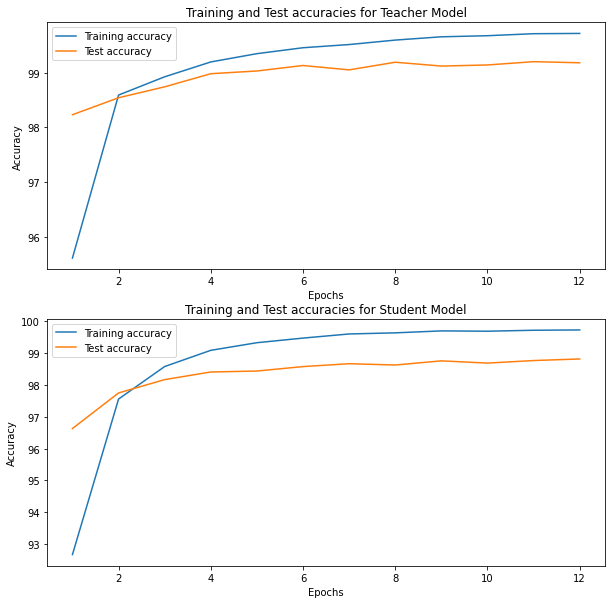

In [17]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize = (10,10))
plt.subplot(2,1,1)
plt.title("Training and Test accuracies for Teacher Model")
plt.plot(range(1, NUM_EPOCHS + 1), teacher_train_acc, label = "Training accuracy")
plt.plot(range(1, NUM_EPOCHS + 1), teacher_test_acc, label = "Test accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(loc = 'best')
# plt.show()

plt.subplot(2,1,2)
plt.title("Training and Test accuracies for Student Model")
plt.plot(range(1, NUM_EPOCHS + 1), student_train_acc_kl, label = "Training accuracy")
plt.plot(range(1, NUM_EPOCHS + 1), student_test_acc_kl, label = "Test accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(loc = 'best')
plt.show()

# Test accuracy vs. tempreture curve

l =  student
Epoch = 1 : Training Loss = 0.005609637126326561, Training Accuracy = 99.61, Test Accuracy = 98.49
Epoch = 2 : Training Loss = 0.03600294142961502, Training Accuracy = 99.62, Test Accuracy = 98.29
Epoch = 3 : Training Loss = 0.008717347867786884, Training Accuracy = 99.70, Test Accuracy = 98.27
Epoch = 4 : Training Loss = 0.013433278538286686, Training Accuracy = 99.74, Test Accuracy = 98.47
Epoch = 5 : Training Loss = 0.016659235581755638, Training Accuracy = 99.78, Test Accuracy = 98.34
Epoch = 6 : Training Loss = 0.02945355325937271, Training Accuracy = 99.77, Test Accuracy = 98.47
Epoch = 7 : Training Loss = 0.008130431175231934, Training Accuracy = 99.76, Test Accuracy = 98.39
Epoch = 8 : Training Loss = 0.0330267958343029, Training Accuracy = 99.77, Test Accuracy = 98.35
Epoch = 9 : Training Loss = 0.012216020375490189, Training Accuracy = 99.76, Test Accuracy = 98.28
Epoch = 10 : Training Loss = 0.007608744781464338, Training Accuracy = 99.78, Test Accuracy = 98.50


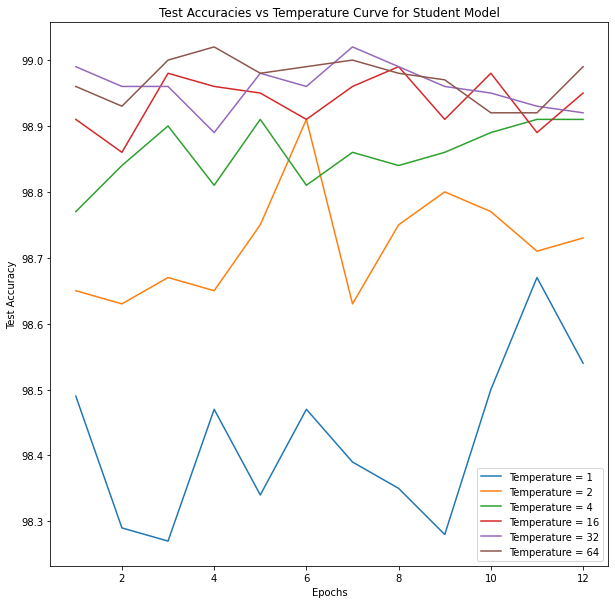

In [19]:
# your code start from here for step 6
temperatures = [1, 2, 4, 16, 32, 64]
ALPHA = 0.5
plt.figure(figsize = (10, 10))
for i, temp in enumerate(temperatures):
    print("\n For Temperature = {}".formt(temp))
    _ , student_test_acc =  train_and_evaluate(fc_model, alpha = ALPHA, temperature= temp, epochs = NUM_EPOCHS, l = "student KL") 
    plt.title("Test Accuracies vs Temperature Curve for Student Model")
    plt.plot(range(1, NUM_EPOCHS + 1), student_test_acc, label = "Temperature = {}".format(temp))
    plt.xlabel("Epochs")
    plt.ylabel("Test Accuracy")
    plt.legend(loc = 'best')
plt.show()

### Training Student Using T = 64

In [18]:
student_train_acc_kl, student_test_acc_kl =  train_and_evaluate(fc_model, alpha = ALPHA, temperature= 64, epochs = NUM_EPOCHS, l = "student KL")

l =  student KL
Epoch = 1 : Training Loss = 9381.478515625, Training Accuracy = 99.62, Test Accuracy = 98.76
Epoch = 2 : Training Loss = 9381.7294921875, Training Accuracy = 99.62, Test Accuracy = 98.86
Epoch = 3 : Training Loss = 9381.5732421875, Training Accuracy = 99.64, Test Accuracy = 98.77
Epoch = 4 : Training Loss = 9384.2744140625, Training Accuracy = 99.68, Test Accuracy = 98.89
Epoch = 5 : Training Loss = 9382.2353515625, Training Accuracy = 99.70, Test Accuracy = 98.86
Epoch = 6 : Training Loss = 9383.3251953125, Training Accuracy = 99.70, Test Accuracy = 98.93
Epoch = 7 : Training Loss = 9380.8232421875, Training Accuracy = 99.73, Test Accuracy = 98.92
Epoch = 8 : Training Loss = 9379.794921875, Training Accuracy = 99.73, Test Accuracy = 98.95
Epoch = 9 : Training Loss = 9377.91796875, Training Accuracy = 99.74, Test Accuracy = 98.94
Epoch = 10 : Training Loss = 9381.6796875, Training Accuracy = 99.75, Test Accuracy = 98.98
Epoch = 11 : Training Loss = 9385.5576171875, Trai

# Train student from scratch

In [19]:
# Build fully connected student.
fc_model_no_distillation = tf.keras.Sequential([

layers.Flatten(),
layers.Dense(784, activation='relu'),
layers.Dense(784, activation='relu'),
layers.Dense(10)
])
# your code start from here for step 7

fc_model_no_distillation.build(input_shape=(256,28,28,1))
fc_model_no_distillation.summary()

#@test {"output": "ignore"}

def compute_plain_cross_entropy_loss(images, labels):
  """Compute plain loss for given images and labels.

  For fair comparison and convenience, this function also performs a
  LogSumExp over subclasses, but does not perform subclass distillation.

  Args:
    images: Tensor representing a batch of images.
    labels: Tensor representing a batch of labels.

  Returns:
    Scalar loss Tensor.
  """
  # your code start from here for step 7

  student_class_logits = fc_model_no_distillation(images, training=True)
  cross_entropy_loss =  tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels, student_class_logits))
  
  return cross_entropy_loss

ALPHA = 0.5
DISTILLATION_TEMPERATURE = 64

student_train_acc, student_test_acc =  train_and_evaluate(fc_model_no_distillation, alpha = ALPHA, temperature= 64, epochs = NUM_EPOCHS, l = "student")

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (256, 784)                0         
                                                                 
 dense_5 (Dense)             (256, 784)                615440    
                                                                 
 dense_6 (Dense)             (256, 784)                615440    
                                                                 
 dense_7 (Dense)             (256, 10)                 7850      
                                                                 
Total params: 1238730 (4.73 MB)
Trainable params: 1238730 (4.73 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


l =  student
Epoch = 1 : Training Loss = 0.10781270265579224, Training Accuracy = 94.04, Test Accuracy = 96.83
Epoch = 2 : Training Loss = 0.05858705937862396, Training Accuracy = 98.03, Test Accuracy = 97.55
Epoch = 3 : Training Loss = 0.08835543692111969, Training Accuracy = 98.86, Test Accuracy = 97.63
Epoch = 4 : Training Loss = 0.05868011713027954, Training Accuracy = 99.32, Test Accuracy = 97.70
Epoch = 5 : Training Loss = 0.06349708139896393, Training Accuracy = 99.54, Test Accuracy = 98.15
Epoch = 6 : Training Loss = 0.023401780053973198, Training Accuracy = 99.64, Test Accuracy = 97.78
Epoch = 7 : Training Loss = 0.009134471416473389, Training Accuracy = 99.72, Test Accuracy = 97.92
Epoch = 8 : Training Loss = 0.015527798794209957, Training Accuracy = 99.72, Test Accuracy = 98.14
Epoch = 9 : Training Loss = 0.0017715629655867815, Training Accuracy = 99.76, Test Accuracy = 98.23
Epoch = 10 : Training Loss = 0.00804174318909645, Training Accuracy = 99.79, Test Accuracy = 98.20
E

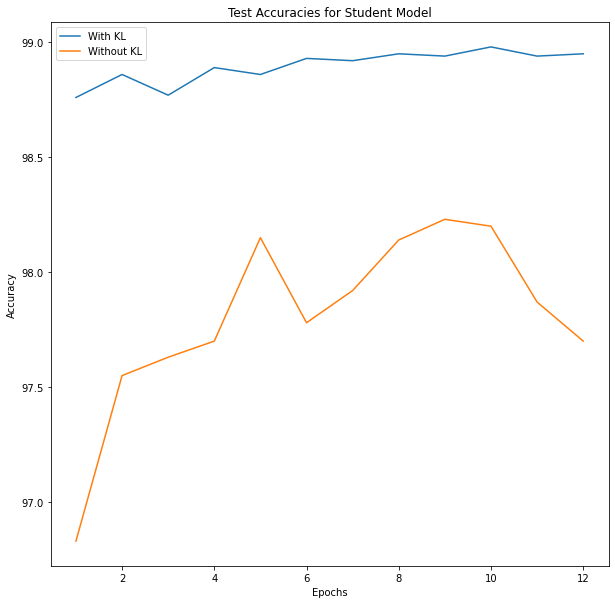

In [21]:
plt.figure(figsize = (10,10))
plt.title("Test Accuracies for Student Model")
plt.plot(range(1, NUM_EPOCHS + 1), student_test_acc_kl, label = "With KL")
plt.plot(range(1, NUM_EPOCHS + 1), student_test_acc, label = "Without KL")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(loc = 'best')
plt.show()

# Comparing the teacher and student model (number of of parameters and FLOPs) 

In [26]:
# your code start from here for step 8
# from keras_flops import get_flops

# teacher_flops = get_flops(cnn_model, batch_size=1)
# print(f"FLOPS for teacher model: {teacher_flops / 10 ** 9:.03} G")

# # flops = get_flops(fc_model, batch_size=1)
# # print(f"FLOPS for student model: {flops / 10 ** 9:.03} G")

print("\n TEACHER MODEL ")
cnn_model.summary()

print("\n STUDENT MODEL ")
fc_model.summary()


 TEACHER MODEL 
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 25, 25, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 23, 23, 64)        18496     
                                                                 
 flatten (Flatten)           (None, 33856)             0         
                                                                 
 dropout (Dropout)           (None, 33856)             0         
                                                                 
 dense (Dense)               (None, 128)               4333696   
                                       

# Implementing the state-of-the-art KD algorithm

In [22]:
# your code start from here for step 12
ta_model = tf.keras.Sequential([
    
layers.Conv2D(32, (3, 3), strides = (1,1), activation='relu', input_shape=(28, 28, 1)),
layers.MaxPooling2D((2, 2), strides = (1,1)),
layers.Flatten(),
layers.Dropout(rate = 0.5),
layers.Dense(128, activation='relu'),
layers.Dropout(rate = 0.5),
layers.Dense(10)
])

In [23]:
def compute_ta_loss(images, labels, distillation_temperature = DISTILLATION_TEMPERATURE, alpha = ALPHA):
  """Compute subclass knowledge distillation student loss for given images
     and labels.

  Args:
    images: Tensor representing a batch of images.
    labels: Tensor representing a batch of labels.

  Returns:
    Scalar loss Tensor.
  """
  ta_class_logits = ta_model(images, training=True)

  # Compute subclass distillation loss between student subclass logits and
  # softened teacher subclass targets probabilities.

  # your code start from here for step 3

  teacher_class_logits = cnn_model(images, training=False)
  distillation_loss_value = distillation_loss(teacher_logits = teacher_class_logits, student_logits = ta_class_logits, temperature = distillation_temperature)

  # print("distillation_loss = ", distillation_loss_value)  
  # Compute cross-entropy loss with hard targets.

  # your code start from here for step 3

  cross_entropy_loss_value = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels, ta_class_logits))
  # print("ce loss = ", cross_entropy_loss_value)
  # cross_entropy_loss_value = cross_entropy_loss_value(labels, student_subclass_logits)

  # return alpha * (distillation_loss_value + cross_entropy_loss_value)
  return alpha * cross_entropy_loss_value + distillation_loss_value

In [24]:
def compute_student_loss(images, labels, distillation_temperature = DISTILLATION_TEMPERATURE, alpha = ALPHA):
  """Compute subclass knowledge distillation student loss for given images
     and labels.

  Args:
    images: Tensor representing a batch of images.
    labels: Tensor representing a batch of labels.

  Returns:
    Scalar loss Tensor.
  """
  student_class_logits = fc_model(images, training=True)
  # print("student_subclass_logits = ", student_subclass_logits)

  # Compute subclass distillation loss between student subclass logits and
  # softened teacher subclass targets probabilities.

  # your code start from here for step 3

  ta_class_logits = ta_model(images, training=False)
  distillation_loss_value = distillation_loss(teacher_logits = ta_class_logits, student_logits = student_class_logits, temperature = distillation_temperature)

  # print("distillation_loss = ", distillation_loss_value)  
  # Compute cross-entropy loss with hard targets.

  # your code start from here for step 3

  cross_entropy_loss_value = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels, student_class_logits))
  # print("ce loss = ", cross_entropy_loss_value)
  # cross_entropy_loss_value = cross_entropy_loss_value(labels, student_subclass_logits)

  # return alpha * (distillation_loss_value + cross_entropy_loss_value)
  return alpha * cross_entropy_loss_value + distillation_loss_value

In [25]:
@tf.function
def compute_num_correct(model, images, labels):
  """Compute number of correctly classified images in a batch.

  Args:
    model: Instance of tf.keras.Model.
    images: Tensor representing a batch of images.
    labels: Tensor representing a batch of labels.

  Returns:
    Number of correctly classified images.
  """
  class_logits = model(images, training=False)
  return tf.reduce_sum(
      tf.cast(tf.math.equal(tf.argmax(class_logits, -1), tf.argmax(labels, -1)),
              tf.float32)), tf.argmax(class_logits, -1), tf.argmax(labels, -1)


def train_and_evaluate(model, alpha, temperature, epochs, l):
  """Perform training and evaluation for a given model.

  Args:
    model: Instance of tf.keras.Model.
    compute_loss_fn: A function that computes the training loss given the
      images, and labels.
  """

  # your code start from here for step 4
  optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)
  train_acc, test_acc = [], []
  print("l = ", l)

  for epoch in range(1, epochs + 1):
    # Run training.
  
    num_correct_train = 0
    num_total_train = builder.info.splits['train'].num_examples
    for images, labels in mnist_train:
      with tf.GradientTape() as tape:
         # your code start from here for step 4
        if l == "teacher":
          loss_value = compute_teacher_loss(images, labels)
        elif l == "student KL":
          loss_value = compute_student_loss(images, labels, distillation_temperature = temperature, alpha = alpha)
        elif l == "student":
          loss_value = compute_plain_cross_entropy_loss(images, labels)
        elif l == "TA":
          loss_value = compute_ta_loss(images, labels, distillation_temperature = temperature, alpha = alpha)


      grads = tape.gradient(loss_value, model.trainable_variables)
      optimizer.apply_gradients(zip(grads, model.trainable_variables))
      num_correct_train += compute_num_correct(model, images, labels)[0]
    
    # Run evaluation for test set
    num_correct_test = 0
    num_total_test = builder.info.splits['test'].num_examples
    for images, labels in mnist_test:
      # your code start from here for step 4
      num_correct_test += compute_num_correct(model, images, labels)[0]
    
    train_ac = num_correct_train / num_total_train * 100
    test_ac = num_correct_test / num_total_test * 100
    train_acc.append(train_ac)
    test_acc.append(test_ac)
    # print("Epoch = {} : Training Loss = {}, Training Accuracy = {:.2f}, Test Accuracy = {:.2f}".format(epoch, loss_value, num_correct_train / num_total_train * 100, num_correct_test / num_total_test * 100 ))
    print("Epoch = {} : Training Loss = {}, Training Accuracy = {:.2f}, Test Accuracy = {:.2f}".format(epoch, loss_value, train_ac, test_ac ))

  
  return train_acc, test_acc

### Training Teacher

In [26]:
teacher_train_acc, teacher_test_acc =  train_and_evaluate(cnn_model, alpha = ALPHA, temperature= 64, epochs = NUM_EPOCHS, l = "teacher")

l =  teacher
Epoch = 1 : Training Loss = 0.013199127279222012, Training Accuracy = 99.70, Test Accuracy = 99.26
Epoch = 2 : Training Loss = 0.023301146924495697, Training Accuracy = 99.75, Test Accuracy = 99.05
Epoch = 3 : Training Loss = 0.024389654397964478, Training Accuracy = 99.76, Test Accuracy = 99.30
Epoch = 4 : Training Loss = 0.0050416928716003895, Training Accuracy = 99.78, Test Accuracy = 99.25
Epoch = 5 : Training Loss = 0.027327511459589005, Training Accuracy = 99.77, Test Accuracy = 99.11
Epoch = 6 : Training Loss = 0.014909903518855572, Training Accuracy = 99.77, Test Accuracy = 99.35
Epoch = 7 : Training Loss = 0.04043469578027725, Training Accuracy = 99.80, Test Accuracy = 99.27
Epoch = 8 : Training Loss = 0.020538894459605217, Training Accuracy = 99.81, Test Accuracy = 99.24
Epoch = 9 : Training Loss = 0.03658166527748108, Training Accuracy = 99.82, Test Accuracy = 99.12
Epoch = 10 : Training Loss = 0.00931093841791153, Training Accuracy = 99.82, Test Accuracy = 99.3

### Training TA

In [27]:
ta_train_acc_kd, ta_test_acc_kd =  train_and_evaluate(ta_model, alpha = ALPHA, temperature= 64, epochs = NUM_EPOCHS, l = "TA")

l =  TA
Epoch = 1 : Training Loss = 9337.958984375, Training Accuracy = 89.84, Test Accuracy = 96.20
Epoch = 2 : Training Loss = 9338.4013671875, Training Accuracy = 96.64, Test Accuracy = 97.44
Epoch = 3 : Training Loss = 9340.1982421875, Training Accuracy = 97.50, Test Accuracy = 97.74
Epoch = 4 : Training Loss = 9340.5751953125, Training Accuracy = 97.85, Test Accuracy = 98.00
Epoch = 5 : Training Loss = 9337.29296875, Training Accuracy = 98.09, Test Accuracy = 98.08
Epoch = 6 : Training Loss = 9335.89453125, Training Accuracy = 98.20, Test Accuracy = 98.12
Epoch = 7 : Training Loss = 9342.00390625, Training Accuracy = 98.34, Test Accuracy = 98.25
Epoch = 8 : Training Loss = 9334.6689453125, Training Accuracy = 98.43, Test Accuracy = 98.26
Epoch = 9 : Training Loss = 9335.6162109375, Training Accuracy = 98.55, Test Accuracy = 98.32
Epoch = 10 : Training Loss = 9338.9345703125, Training Accuracy = 98.57, Test Accuracy = 98.39
Epoch = 11 : Training Loss = 9335.9970703125, Training Acc

### Training Student

In [28]:
student_train_acc_kd, student_test_acc_kd =  train_and_evaluate(fc_model, alpha = ALPHA, temperature= 64, epochs = NUM_EPOCHS, l = "student KL")

l =  student KL
Epoch = 1 : Training Loss = 9345.86328125, Training Accuracy = 99.30, Test Accuracy = 98.47
Epoch = 2 : Training Loss = 9356.283203125, Training Accuracy = 99.20, Test Accuracy = 98.46
Epoch = 3 : Training Loss = 9350.654296875, Training Accuracy = 99.21, Test Accuracy = 98.39
Epoch = 4 : Training Loss = 9349.83203125, Training Accuracy = 99.22, Test Accuracy = 98.37
Epoch = 5 : Training Loss = 9346.203125, Training Accuracy = 99.20, Test Accuracy = 98.32
Epoch = 6 : Training Loss = 9357.3916015625, Training Accuracy = 99.24, Test Accuracy = 98.32
Epoch = 7 : Training Loss = 9350.7861328125, Training Accuracy = 99.22, Test Accuracy = 98.29
Epoch = 8 : Training Loss = 9352.38671875, Training Accuracy = 99.25, Test Accuracy = 98.37
Epoch = 9 : Training Loss = 9341.6005859375, Training Accuracy = 99.27, Test Accuracy = 98.38
Epoch = 10 : Training Loss = 9348.1767578125, Training Accuracy = 99.27, Test Accuracy = 98.41
Epoch = 11 : Training Loss = 9346.4580078125, Training 

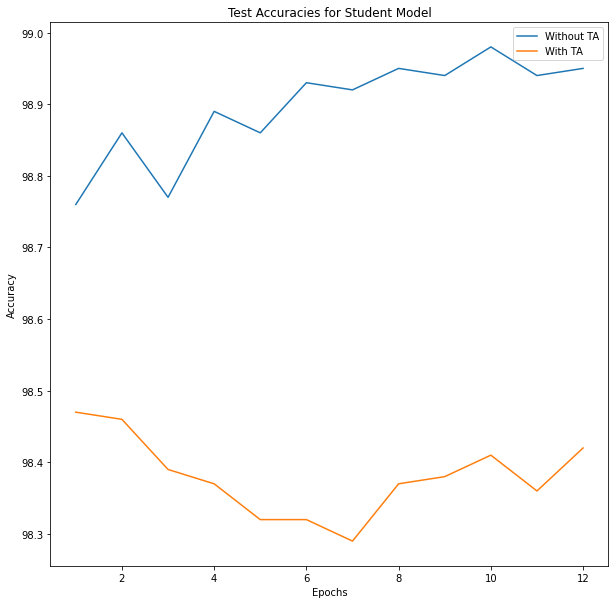

In [29]:
plt.figure(figsize = (10,10))
plt.title("Test Accuracies for Student Model")
plt.plot(range(1, NUM_EPOCHS + 1), student_test_acc_kl, label = "Without TA")
plt.plot(range(1, NUM_EPOCHS + 1), student_test_acc_kd, label = "With TA")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(loc = 'best')
plt.show()

# XAI method to explain models

In [9]:
# your code start from here for step 13

from gradcam import *
import cv2



In [ ]:
# XAI on the teacher model.
for image, label in mnist_test:
  cam = grad_cam(cnn_model, np.expand_dims(image[0].numpy().squeeze(1), axis=0), 'conv2d')
  # print(cam.shape)
  cam = (cam*255).astype("uint8")
  # print(cam.shape)
  cam = cv2.applyColorMap(cam, cv2.COLORMAP_JET)
  # print(cam.shape)
  # cam = np.repeat(cam, 2, axis=0)
  # # print(cam.shape)
  # cam = np.repeat(cam, 2, axis=1)
  # print(cam.shape)
  img = cam + image[0]
  img = np.clip(img,0,255).astype("uint8")
  # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  fig,ax = plt.subplots(1,2,figsize=(10,10))
  ax[0].imshow(image[0])
  ax[1].imshow(img)
  ax[0].axis('off')
  ax[1].axis('off')
  break

In [ ]:
# XAI on the distilled model.
for image, label in mnist_test:
  cam = grad_cam(fc_model, np.expand_dims(image[0].numpy(), axis=0), 'dense_2')
  #print(cam.shape)
  cam = (cam*255).astype("uint8")
  cam = cv2.applyColorMap(cam, cv2.COLORMAP_JET)
  img = cam + image[0].numpy()
  img = np.clip(img,0,255).astype("uint8")
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  fig,ax = plt.subplots(1,2,figsize=(10,10))
  ax[0].imshow(image[0].numpy().reshape(28,28))
  ax[1].imshow(img)
  ax[0].axis('off')
  ax[1].axis('off')
  break